# Gaussian Kernal Density Estimation (method 2)

This code uses the KDE function from sci-kit learn package to find the smoothing curve over the 2D histogram of particle counts in the horizontal plane and plots it over a grid with the same resolution as the particles' trajectories.

It takes into account the grid cells that are over land to avoid unrealistic results.

-Author: Jimena Medina Rubio

-Created on: 18/03/2023

### 0. Imports and package versions

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean
import cmocean.cm as cmo
import pandas as pd
from scipy.interpolate import griddata
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

### 1. Loading the data

In [2]:
#select path of directory
path="/Users/lienzo/Desktop/Thesis/Parcelscodes/"

#import OceanParcels output in netCDF
file="toy_data_01.nc"

ds=xr.open_dataset(path+file)
print(ds.keys)

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical>


### 2. Definition of functions

In [3]:
def land_mask_interpolated(land_mask, ds, bins_x, bins_y):
    
    """
    Interpolates the input land_mask from a netCDF file to the desired grid on which the KDE function
    is displayed. The number of grid cells in the zonal & meridional direction is bins_x & bins_y respectively
    
    """
    
    #use boolean indexing to select the values of longitude & latitude inside the domain
    land_mask = land_mask.sel(lat=slice(ds['lat'].min(), ds['lat'].max()), 
                              lon=slice(ds['lon'].min(), ds['lon'].max()))

    #define fine grid coordinates
    fine_x, fine_y = np.meshgrid(np.arange(0, np.shape(land_mask)[1]), np.arange(0, np.shape(land_mask)[0]))

    #define coarse grid coordinates with binx_x & bins_y cells in the x/y direction
    coarse_x, coarse_y = np.meshgrid(np.linspace(0, np.shape(land_mask)[1], bins_x), np.linspace(0, np.shape(land_mask)[0], bins_y))
    
    #flatten fine grid coordinates and mask
    flat_x, flat_y, flat_mask = fine_x.flatten(), fine_y.flatten(), land_mask.stack(z=('lat', 'lon'))

    #interpolate mask onto coarse grid
    coarse_mask = griddata((flat_x, flat_y), flat_mask, (coarse_x, coarse_y), method='nearest')
    
    #set NaN values in ocean
    coarse_mask[coarse_mask==100]=np.nan
    
    #create boolean mask in the same grid as used in kde with True in ocean
    ocean=np.isnan(coarse_mask)
    
    return ocean

In [4]:
def kde_landmask(ds, bins_x, bins_y, ocean):
    
    """
    Calculates the smoothing Gaussian function of the longitude and latitude samples from the particles' locations
    at each observation from the Dataset 'ds'. The bandwidth of such function is fitted to the samples and the 
    resulting heat map is shown over an adjustable grid controlled by the parameters 'binx_x' & 'bins_y'.
    
    The input land mask 'ocean' is a boolean mask that restricts the KDE values to the ocean.
    """
    #initialize an empty list to store the KDE values for each observation
    kde_values = []

    #loop over each observation in the dataset
    for i in range(ds.obs.size):
    
        #extract the lon/lat values for the current observation
        lon_lat  = np.vstack([ds.lat[:,i], ds.lon[:,i]]).T
    
        #create a 2D grid of lat/lon values to evaluate the KDE on based on
        x, y = np.meshgrid(np.linspace(ds['lon'].min(), ds['lon'].max(), bins_x), np.linspace(ds['lat'].min(), ds['lat'].max(), bins_y))
        
        #flatten grid & the ocean mask
        xy = np.column_stack([y.ravel(), x.ravel()])
        ocean=ocean.ravel()
        
        #only consider points from xy grid in ocean
        xy = xy[ocean]
    
        #initialize a KDE object & fit it to the lon/lat values from the trajectories
        kde = KernelDensity( kernel="gaussian", algorithm="ball_tree")
        
        #suggest a range of possible values of bandwidth & find best fit
        bandwidth = np.arange(0.02, 1, 0.05)
        grid = GridSearchCV(kde, {'bandwidth': bandwidth})
        
        #find KDE for the given lat/lon values
        grid.fit(lon_lat)
        kde = grid.best_estimator_

        #evaluate the KDE on the 2D grid created & get log-likelihood
        log_density = kde.score_samples(xy)
        
        #obtain probability at each grid cell
        density = np.exp(log_density)
        
        #normalise results
        density /= density.sum()
        
        #initialise output matrix
        z = np.zeros(x.shape)
        
        #only keep values in the ocean
        z.ravel()[ocean] = density
        z.resize(x.shape)
        
        # append the KDE values of each grid cell to the list
        kde_values.append(z)
    
    #combine the KDE values into a DataArray
    kde_values = np.stack(kde_values)
    kde_da = xr.DataArray(kde_values,
                      dims=("obs", "lat", "lon"),
                      coords={"obs": ds.obs.values,
                              "lat": y[:, 0],
                              "lon": x[0, :]},
                      name="%")
    
    #print the used bandwidth
    print("optimal bandwidth: " + "{:.2f}".format(kde.bandwidth))

    #compute the cumulative sum of the particle distribution over time
    kde_total=np.sum(kde_da, axis=0)
    
    #obtain normalised result in percentage
    kde_total = kde_total*100/np.nansum(kde_total)
    
    #set to NaN zero value
    kde_total=kde_total.where(kde_total!= 0, np.nan)
    
    return kde_total

In [5]:

def probability_map(probability, xlim, ylim, title):
    
    """ All-included plot of the desired domain specified by xlim & ylim """
    
    fig=plt.figure(figsize=(13,6)) 
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0.0))

    #create grid with [min, max] values of lons & lats
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    #plot coastlines
    ax.coastlines(resolution='10m')
    ax.add_feature(cartopy.feature.LAND, facecolor='grey')

    #draw grid lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    #plot probability results 
    probability.plot(ax=ax, cmap=cmo.matter)
    plt.title(title)
                
    return plt.show()

### 3. Results

**OBTAINING LAND MASK TO EXCLUDE FROM KDE ANALYSIS**

Method: imput fine resolution land mask and interpolate it to the grid used to display the KDE on. 
Download land sea mask from <a href="https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf" target="_blank">NASA website</a>

KeysView(<xarray.Dataset>
Dimensions:      (lon: 3602, lat: 1800)
Coordinates:
  * lon          (lon) float64 -0.05 0.05 0.15 0.25 ... 359.8 359.9 360.0 360.1
  * lat          (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    landseamask  (lat, lon) float32 ...)


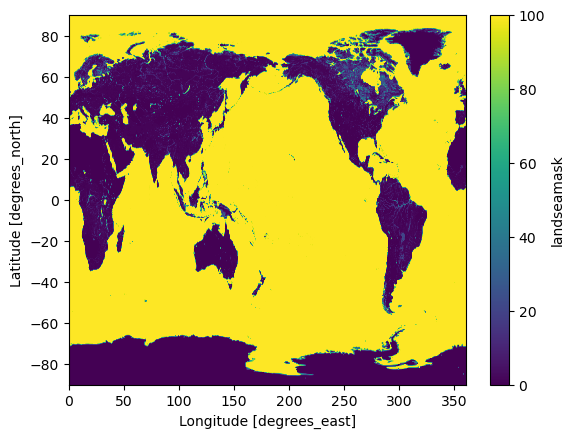

In [6]:
#import land mask
land=xr.open_dataset('/Users/lienzo/Downloads/IMERG_land_sea_mask.nc')
print(land.keys())
land['landseamask'].plot()

In [7]:
#choose bin size of the output grid
bins_x=100
bins_y=100

#interpolate land mask to output grid
ocean=land_mask_interpolated(land['landseamask'], ds,  bins_x, bins_y)

#calculate KDE over output grid
kde_results=kde_landmask(ds, bins_x, bins_y, ocean)

optimal bandwidth: 0.92


### 4. Plotting results

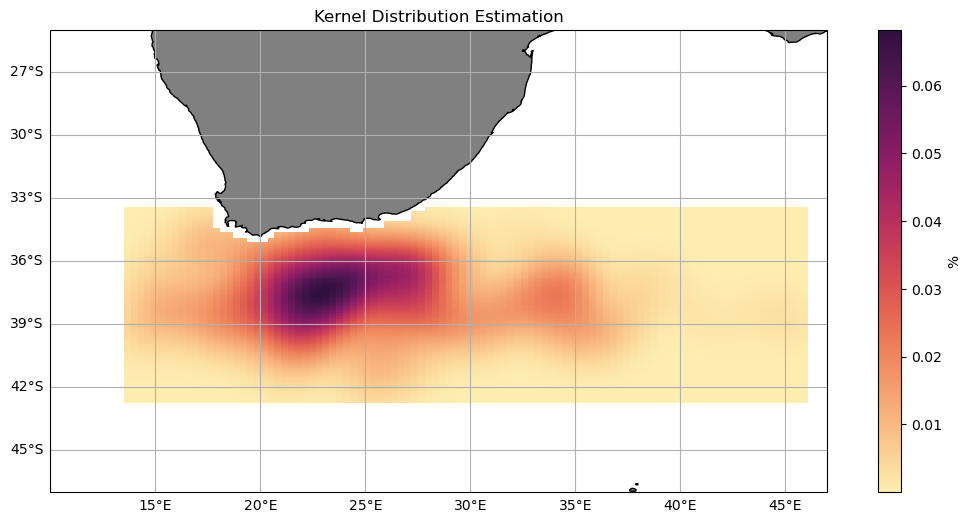

In [8]:
#choose the limits of the x & y axis of the graph
xlim=[10, 47]
ylim= [-47, -25]

#plot results
probability_map(kde_results, xlim, ylim, 'Kernel Distribution Estimation')